In [2]:
from python_speech_features import mfcc
import scipy.io.wavfile as wav
import numpy as np

from tempfile import TemporaryFile
import os
import pickle
import random 
import operator

import math
import numpy as np

In [3]:
def distance_mahalanobis(instance1, instance2, k=None, eps=1e-6):
    """
    單向 Mahalanobis distance
    """
    mean1, cov1, _ = instance1
    mean2, _, _    = instance2

    diff = mean1 - mean2
    dim = cov1.shape[0]
    cov1_reg = cov1 + eps * np.eye(dim)
    inv_cov1 = np.linalg.inv(cov1_reg)
    return diff.T @ inv_cov1 @ diff

def distance_kl(instance1, instance2, k=None):
    """
    Kullback-Leibler Divergence
    """
    mm1, cm1, _ = instance1
    mm2, cm2, _ = instance2
    dim = cm1.shape[0]
    
    term1 = np.trace(np.dot(np.linalg.inv(cm2), cm1))
    diff = mm2 - mm1
    term2 = np.dot(np.dot(diff.transpose(), np.linalg.inv(cm2)), diff)
    term3 = np.log(np.linalg.det(cm2)) - np.log(np.linalg.det(cm1))
    
    return term1 + term2 + term3 - dim

def getNeighbors(trainingSet, instance, k, distance_func=distance_mahalanobis):
    distances = []
    for x in range(len(trainingSet)):
        dist = distance_func(trainingSet[x], instance, k) + distance_func(instance, trainingSet[x], k)
        distances.append((trainingSet[x][2], dist))
    distances.sort(key=operator.itemgetter(1))
    neighbors = []
    for x in range(k):
        neighbors.append(distances[x][0])
    return neighbors

def nearestClass(neighbors):
    classVote = {}
    for response in neighbors:
        if response in classVote:
            classVote[response] += 1
        else:
            classVote[response] = 1
    sorter = sorted(classVote.items(), key=operator.itemgetter(1), reverse=True)
    return sorter[0][0]

In [4]:
def getAccuracy(testSet, predictions):
    correct = 0 
    for x in range (len(testSet)):
        if testSet[x][-1]==predictions[x]:
            correct+=1
    return 1.0*correct/len(testSet)

In [5]:
directory = "genres/"
f= open("my.dat" ,'wb')
i=0
for folder in os.listdir(directory):
    if not os.path.isdir(os.path.join(directory, folder)):
        continue
    i+=1
    if i==11 :
        break   
    for file in os.listdir(directory+folder):  
        (rate,sig) = wav.read(directory+folder+"/"+file)
        mfcc_feat = mfcc(sig,rate ,winlen=0.020, appendEnergy = False)
        covariance = np.cov(np.matrix.transpose(mfcc_feat))
        mean_matrix = mfcc_feat.mean(0)
        feature = (mean_matrix , covariance , i)
        pickle.dump(feature , f)
        print(f"File: {folder}/{file}")
        print(f"Genre index: {i}")
        print(f"MFCC Features shape: {mfcc_feat.shape}")
        print(f"Mean Matrix: {mean_matrix}")
        print(f"Covariance Matrix shape: {covariance.shape}")
        print(f"Feature tuple: (mean_matrix, covariance, genre_index={i})")
        print("-" * 80)
f.close()

File: blues/blues.00000.wav
Genre index: 1
MFCC Features shape: (2994, 13)
Mean Matrix: [ 76.50261107  -1.96141736 -15.7743469    3.8314189  -10.47332553
   1.31182833 -19.39373183   5.28678994 -16.63172467   5.3534445
  -9.85657026   6.25007663  -5.58749505]
Covariance Matrix shape: (13, 13)
Feature tuple: (mean_matrix, covariance, genre_index=1)
--------------------------------------------------------------------------------
File: blues/blues.00001.wav
Genre index: 1
MFCC Features shape: (2994, 13)
Mean Matrix: [ 66.93164965   0.71885345  -3.26783036   4.18120038  -8.05094092
   6.4482592  -17.76851742  14.09181008 -18.33253624   3.68556046
 -10.55074362   2.88748511  -7.78808286]
Covariance Matrix shape: (13, 13)
Feature tuple: (mean_matrix, covariance, genre_index=1)
--------------------------------------------------------------------------------
File: blues/blues.00002.wav
Genre index: 1
MFCC Features shape: (2994, 13)
Mean Matrix: [ 78.77410313   3.03970009 -19.02443546  -0.98359

In [6]:
dataset = []
def loadDataset(filename , split , trSet , teSet):
    with open("my.dat" , 'rb') as f:
        while True:
            try:
                dataset.append(pickle.load(f))
            except EOFError:
                f.close()
                break  

    for x in range(len(dataset)):
        if random.random() <split :      
            trSet.append(dataset[x])
        else:
            teSet.append(dataset[x])  

trainingSet = []
testSet = []
loadDataset("my.dat" , 0.66, trainingSet, testSet)

In [7]:
leng = len(testSet)

print("--- Mahalanobis Distance ---")
predictions_mah = []
for x in range(leng):
    # print(f"Classifying test sample {x+1}/{leng}")
    predictions_mah.append(nearestClass(getNeighbors(trainingSet, testSet[x], 5, distance_func=distance_mahalanobis)))

accuracy_mah = getAccuracy(testSet, predictions_mah)
print("Accuracy (Mahalanobis):", accuracy_mah)

print("\n--- KL Divergence ---")
predictions_kl = []
for x in range(leng):
    # print(f"Classifying test sample {x+1}/{leng}")
    predictions_kl.append(nearestClass(getNeighbors(trainingSet, testSet[x], 5, distance_func=distance_kl)))

accuracy_kl = getAccuracy(testSet, predictions_kl)
print("Accuracy (KL Divergence):", accuracy_kl)

--- Mahalanobis Distance ---
Accuracy (Mahalanobis): 0.6421725239616614

--- KL Divergence ---
Accuracy (KL Divergence): 0.7188498402555911


C:\Users\USER\AppData\Local\Temp\ipykernel_24256\1549485878.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_labels))


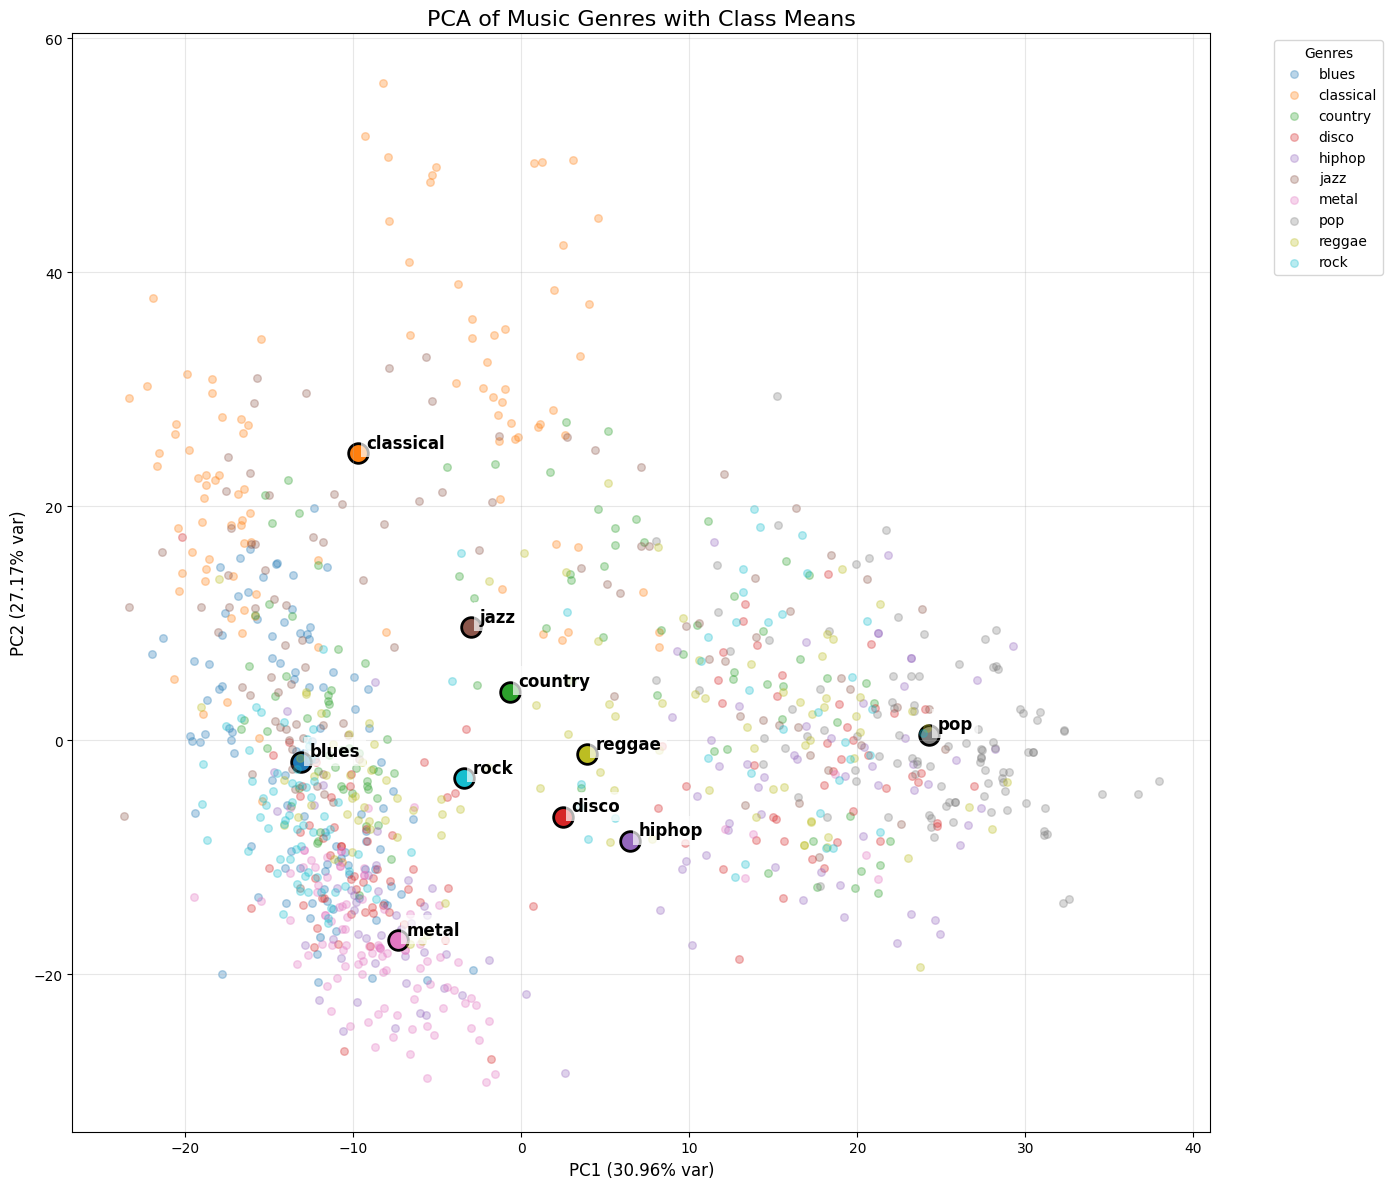

In [9]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

# Genre 名稱映射 (根據 index 1-10)
genre_map = {
    1: 'blues',
    2: 'classical',
    3: 'country',
    4: 'disco',
    5: 'hiphop',
    6: 'jazz',
    7: 'metal',
    8: 'pop',
    9: 'reggae',
    10: 'rock'
}

# 收集數據
all_data = []
all_labels = []

for instance in trainingSet + testSet:
    all_data.append(instance[0])
    all_labels.append(instance[2])

X = np.array(all_data)
y = np.array(all_labels)

# PCA 降維
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# 繪圖
plt.figure(figsize=(14, 12))
unique_labels = np.unique(y)
colors = plt.cm.get_cmap('tab10', len(unique_labels))

for i, label in enumerate(unique_labels):
    mask = (y == label)
    genre_name = genre_map.get(label, f"{label}")
    
    # 1. 繪製該 Genre 的所有點 (透明度較高，作為背景)
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1], 
                label=genre_name, 
                color=colors(i), 
                alpha=0.3, 
                s=30)
    
    # 2. 計算並繪製該 Genre 的「中心點 (Mean)」
    mean_x = np.mean(X_pca[mask, 0])
    mean_y = np.mean(X_pca[mask, 1])
    
    # 畫一個黑色邊框的大圓點代表中心
    plt.scatter(mean_x, mean_y, 
                color=colors(i), 
                edgecolor='black', 
                linewidth=2, 
                s=200, 
                marker='o')
    
    # 3. 在中心點旁標上文字
    plt.text(mean_x + 0.5, mean_y + 0.5, genre_name, 
             fontsize=12, 
             fontweight='bold', 
             bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

plt.title('PCA of Music Genres with Class Means', fontsize=16)
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} var)', fontsize=12)
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} var)', fontsize=12)
plt.legend(title='Genres', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
